# MANUAL DATA COLLECTION

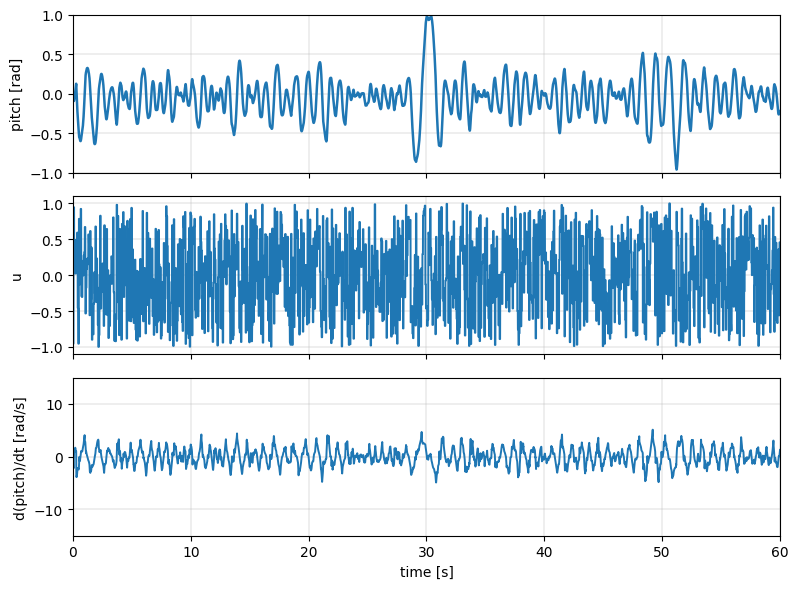

Done. Samples: 60001  Sim time: 60.001s


In [2]:
# MuJoCo viewer (real-time paced) + live 3-row plot (pitch [rad], action, pitch rate [rad/s])

import time, math, numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import mujoco as mj
import mujoco.viewer as viewer

# -------- config --------
CTRL_DT   = 0.05          # control update period (sim seconds)
DURATION  = 60.0          # total run time (sim seconds)
U_MIN, U_MAX = -1.0, 1.0  # throttle bounds
RTF      = 1.0            # realtime factor: 1.0=real-time, 0.5=half-speed, 2.0=2x
REFRESH_HZ = 6            # plot refresh rate (wall-clock)

# XML path
try:
    MODEL_XML = file_name
except NameError:
    MODEL_XML = "monstertruck.xml"

# -------- quat -> RPY (ZYX), radians --------
def quat_to_rpy_rad(qw, qx, qy, qz):
    R00 = 1 - 2*(qy*qy + qz*qz)
    R10 = 2*(qx*qy + qw*qz)
    R20 = 2*(qx*qz - qw*qy)
    R21 = 2*(qy*qz + qw*qx)
    R22 = 1 - 2*(qx*qx + qy*qy)
    yaw   = math.atan2(R10, R00)
    pitch = -math.asin(max(-1.0, min(1.0, R20)))
    roll  = math.atan2(R21, R22)
    return roll, pitch, yaw

def angdiff(a, b):
    """Return wrapped difference a-b in (-pi, pi]."""
    return ((a - b + math.pi) % (2.0*math.pi)) - math.pi

# -------- model --------
m = mj.MjModel.from_xml_path(MODEL_XML)
d = mj.MjData(m)
mj.mj_resetData(m, d); mj.mj_forward(m, d)
d.ctrl[:] = 0.0

sim_dt        = float(m.opt.timestep)
steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qadr   = m.jnt_qposadr[free_j] + 3  # qw,qx,qy,qz start

# -------- live plot setup --------
plt.ioff()  # we'll redraw manually via clear_output
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

(line_pitch,) = ax1.plot([], [], lw=1.8)
(line_u,)     = ax2.plot([], [], lw=1.4)
(line_rate,)  = ax3.plot([], [], lw=1.4)

ax1.set_ylabel("pitch [rad]")
ax1.set_ylim(-1, 1)
ax1.grid(True, linewidth=0.3)

ax2.set_ylabel("u")
ax2.set_ylim(-1.1, 1.1)
ax2.grid(True, linewidth=0.3)

ax3.set_ylabel("d(pitch)/dt [rad/s]")
ax3.set_xlabel("time [s]")
ax3.set_ylim(-15, 15)   # adjust if you see clipping
ax3.grid(True, linewidth=0.3)

fig.tight_layout()
display(fig)

# -------- run viewer --------
t_log, pitch_log, u_log, rate_log = [], [], [], []
last_refresh_wall = time.perf_counter()

with viewer.launch_passive(m, d) as v:
    t0_sim   = d.time
    t0_wall  = time.perf_counter()
    next_cmd = t0_sim
    u = 0.0

    prev_pitch = None

    while d.time - t0_sim < DURATION:
        # choose a new random throttle every CTRL_DT (sim time)
        if d.time >= next_cmd:
            u = float(np.random.uniform(U_MIN, U_MAX))
            d.ctrl[:] = u
            next_cmd += CTRL_DT

        # one physics tick
        mj.mj_step(m, d)

        # read pitch and compute pitch rate (wrapped finite diff over sim_dt)
        qw, qx, qy, qz = d.qpos[qadr:qadr+4]
        _, pitch, _ = quat_to_rpy_rad(qw, qx, qy, qz)

        if prev_pitch is None:
            rate = 0.0
        else:
            rate = angdiff(pitch, prev_pitch) / sim_dt
        prev_pitch = pitch

        t_rel = d.time - t0_sim
        t_log.append(t_rel); pitch_log.append(pitch); u_log.append(u); rate_log.append(rate)

        # live-plot at REFRESH_HZ (wall time)
        now = time.perf_counter()
        if now - last_refresh_wall >= 1.0 / REFRESH_HZ:
            line_pitch.set_data(t_log, pitch_log)
            line_u.set_data(t_log, u_log)
            line_rate.set_data(t_log, rate_log)
            ax1.set_xlim(0.0, max(5.0, t_rel))
            clear_output(wait=True)
            display(fig)
            last_refresh_wall = now

        # real-time pacing
        sim_elapsed  = d.time - t0_sim
        target_wall  = t0_wall + sim_elapsed / max(1e-9, RTF)
        sleep_needed = target_wall - time.perf_counter()
        if sleep_needed > 0:
            time.sleep(min(sleep_needed, 0.01))

        v.sync()

# final draw
line_pitch.set_data(t_log, pitch_log)
line_u.set_data(t_log, u_log)
line_rate.set_data(t_log, rate_log)
ax1.set_xlim(0.0, max(5.0, t_log[-1] if t_log else 5.0))
clear_output(wait=True)
display(fig)

print(f"Done. Samples: {len(t_log)}  Sim time: {t_log[-1]:.3f}s")


# GAUSSIAN PROCESS DYNAMICS

In [3]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var

In [ ]:
import gymnasium as gym
# import gym
import numpy as np
import torch
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1.  Environment setup
# --------------------------------------------------------------
n_state = 2    # [position, velocity]
n_action = 1        # 1 continuous action
n_output = 2                                # Δpos, Δvel


# --------------------------------------------------------------
# 2.  Collect initial random data
# --------------------------------------------------------------
data = {'X': [], 'Y': []}

obs, _ = env.reset(seed=0)
for _ in range(200):  # collect 500 transitions
    a = env.action_space.sample()  # random continuous action in [-1,1]
    x_next, r, term, trunc, _ = env.step(a)
    data['X'].append(np.concatenate([obs, a]))   # [pos, vel, action]
    data['Y'].append(x_next - obs)               # Δstate
    obs = x_next
    if term or trunc:
        obs, _ = env.reset()

X = np.array(data['X'])[::3]
Y = np.array(data['Y'])[::3]
print(f"Collected {len(X)} transitions.")


# --------------------------------------------------------------
# 3.  Train GP dynamics models
# --------------------------------------------------------------
gps = [GPManager(kernel='RBF', iters=300) for _ in range(n_output)]

for d in range(n_output):
    gps[d].fit(X, Y[:, d])
    print(f"Trained GP for Δstate[{d}] with {len(X)} samples.")